In [1]:
import pandas as pd, numpy as np, glob
from Bio.Seq import Seq

from matplotlib import pyplot as plt

import warnings
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

def makeorf(df,fill='.'):
    ref = Seq(''.join(df[(df.Ref!='.')]['Ref'].tolist()))
    alt = Seq(''.join(df[(df.Alt!='.')]['Alt'].tolist()))
    
    if df.Strand.min() < 0:
        ref = ref.reverse_complement()
        alt = alt.reverse_complement()
        
    return ref,alt

In [2]:
%matplotlib inline

In [3]:
## Bring in genetic variants
gv = pd.read_csv('../DATA/GENOTYPE/CDx-ill-SNP-INDEL-df-104-blocked.csv.gz')
gv['Chromosome'] = [int(c[-2:]) for c in gv.Chrom]
gv.shape

(92103, 126)

In [4]:
## Name genes
ric8_name = 'CNN01270'
ssk1_name = 'CNB03090'

In [5]:
## Bring in chrommap
chrommap = pd.read_csv('../DATA/XL280-chrom-map.csv')
chrommap.head()

,Chromosome,Chromnumber,Length
0,Chr01,1,2300525
1,Chr02,2,1632286
2,Chr03,3,2105722
3,Chr04,4,1783052
4,Chr05,5,1507536


In [6]:
## Bring in GFF file
gffpath = '../DATA/xl280genome.gff3.csv.gz'
gff = pd.read_csv(gffpath,index_col=0)

descriptions = ['hypothetical protein',
                'unspecified product',
                'conserved hypothetical protein']

foi = ['gene','three_prime_UTR','five_prime_UTR','CDS']


gff.columns = [c.capitalize() for c in gff.columns]

gff['Seqid'] = gff['Contig']
gff['Strand'] = gff['Strand'].replace(dict(zip(['-','+'],[-1,1])))
gff['Parent'] = [a.split('Parent=')[-1].split(';')[0].split('ID=')[-1] 
                 for a in gff.Attribute ]

genes = gff[(gff.Type=='gene')].sort_values('Start').copy()

genes['Description'] = [a.split('description=')[-1].split('%2C')[0] 
                        for a in genes.Attribute]

genes['Chromosome'] = [int(a[-2:]) for a in genes.Contig]

genes.sort_values(['Chromosome','Start'],inplace=True)

genes.head()

,Type,Gene,Start,End,Strand,Contig,Phase,Attribute,Description,Id,Seqid,Parent,Chromosome
7608,gene,CNA00070,22944,24311,1,Chr01,.,ID=CNA00070;description=proteolysis and peptid...,proteolysis and peptidolysis-related protein,CNA00070,Chr01,CNA00070,1
16204,gene,CNA00120,38576,39065,-1,Chr01,.,ID=CNA00120;description=chaperone%2C putative,chaperone,CNA00120,Chr01,CNA00120,1
39845,gene,CNA00130,39165,43089,1,Chr01,.,ID=CNA00130;description=expressed protein,expressed protein,CNA00130,Chr01,CNA00130,1
97354,gene,CNA00140,42992,45218,-1,Chr01,.,ID=CNA00140;description=adenosylmethionine dec...,adenosylmethionine decarboxylase,CNA00140,Chr01,CNA00140,1
45788,gene,CNA00150,45283,46801,-1,Chr01,.,ID=CNA00150;description=holocytochrome-c synth...,holocytochrome-c synthase,CNA00150,Chr01,CNA00150,1


In [7]:
samplespath = sorted(glob.glob('../DATA/GENOTYPE/GENES/*/*.csv.gz'))
samplespath[:5],len(samplespath)

(['../DATA/GENOTYPE/GENES/SS-A837/CNB02870-t26_1.csv.gz',
  '../DATA/GENOTYPE/GENES/SS-A837/CNB02995-t26_1.csv.gz',
  '../DATA/GENOTYPE/GENES/SS-A837/CNB03000-t26_1.csv.gz',
  '../DATA/GENOTYPE/GENES/SS-A837/CNB03005-t26_1.csv.gz',
  '../DATA/GENOTYPE/GENES/SS-A837/CNB03010-t26_1.csv.gz'],
 123)

if temp.Strand.min() == -1:
    
        temp = temp[::-1]
        temp['Ref'] = [str(Seq(r).reverse_complement()) for r in temp.Ref]
        temp['Alt'] = [str(Seq(r).reverse_complement()) for r in temp.Alt]
        temp.reset_index(drop=True,inplace=True)

    temp['Codon'] = -1
    temp['Ref_aa'] = -1
    temp['Alt_aa'] = -1

    ref_cds_ix = temp[(temp.Ref!='.') & (temp.Type==0)].index
    codon_iter = np.arange(0,len(ref_cds_ix),3)

    for k,i in enumerate(codon_iter):
    
        temp.loc[ref_cds_ix[i:i+3],'Codon'] = k
    
        temp.loc[ref_cds_ix[i:i+3],'Ref_aa'] = Seq(''.join(temp.loc[
                                        ref_cds_ix[i:i+3],
                                            'Ref'].tolist())).translate()
    
    alt_cds_ix = temp[(temp.Alt!='.') & (temp.Type==0)].index    
    for k,i in enumerate(codon_iter):
        #print(k)
        temp.loc[alt_cds_ix[i:i+3],'Alt_aa'] = Seq(''.join(temp.loc[
                                        alt_cds_ix[i:i+3],
                                            'Alt'].tolist())).translate()
    
    ns = temp[(temp.Ref_aa!=temp.Alt_aa) & (
            temp.Codon>0)].Codon.unique().shape[0]

In [8]:
todf = []
for s in samplespath:

    sample = s.split('GENES/')[-1].split('/')[0]
    genep = s.split('/')[-1].split('.csv')[0]
    gene_name = s.split('/')[-1].split('-t26')[0]

    temp = pd.read_csv(s,index_col=0).reset_index(drop=True)
    gene = temp.Gene.min()
    assert sample == temp.Sample.min()
    assert gene == genep
        
    cds = temp[(temp.Type==0)]
        
    ref,alt = makeorf(cds)
        
    el = cds.Pos.unique().shape[0]/3-1
        
    ra = ref.translate(to_stop=True)
    aa = alt.translate(to_stop=True)
        
    rl = len(ra)
    al = len(aa)
        
    sr = ref.translate().count('*')
    sa = alt.translate().count('*')
        
    ns = sa - 1
    for i in range(np.min([len(ra),len(aa)])):
        if ra[i]!=aa[i]:
            ns = ns + 1
            
    nvars = temp[(temp.Isvar==1)].shape[0]
    utr3 = temp[(temp.Type==3) & (temp.Isvar==1)].shape[0]
    utr5 = temp[(temp.Type==5) & (temp.Isvar==1)].shape[0]
    inexon = temp[(temp.Type==0) & (temp.Isvar==1)].shape[0]
    inintron = temp[(temp.Type==-1) & (temp.Isvar==1)].shape[0]
    
    
        
    todf.append((sample,gene_name,gene,
                 el,rl,al,sr,sa,ns,
                 nvars,utr5,utr3,inexon,inintron
                ))

In [9]:
resdf = pd.DataFrame(todf,
        columns=['Strain','Gene','Parent','Expected',
                 'Ref','Alt','Refstop','Altstop','Nonsyn',
                 'Nvars','Utr5','Utr3','Exon','Intron'
                ])
resdf.tail()

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron
118,SS-A837,CNN01400,CNN01400-t26_1,1055.0,1055,1055,1,1,1,47,0,2,24,21
119,SS-A837,CNN01410,CNN01410-t26_1,883.0,883,883,1,1,2,76,1,1,14,60
120,SS-A837,CNN01420,CNN01420-t26_1,143.0,143,143,1,1,0,9,0,1,0,8
121,SS-A837,CNN01430,CNN01430-t26_1,428.0,428,428,1,1,2,46,0,2,25,19
122,SS-A837,CNN01440,CNN01440-t26_1,274.0,274,274,1,1,1,37,0,1,5,31


In [10]:
resdf[(resdf.Gene=='CNN01320')]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron
109,SS-A837,CNN01320,CNN01320-t26_1,215.0,215,215,1,1,1,83,5,56,9,13


In [11]:
to_sheet = resdf[(resdf.Strain=='SS-A837') #| (resdf.Gene==ric8_name)
                ].merge(genes[(genes.Gene.isin(resdf.Gene))][
                ['Gene','Description','Contig','Strand','Start','End']])

In [12]:
no_vars_a = pd.read_csv('../DATA/GENOTYPE/GENES/SS-A837/NOVARS.csv',
                        header=None, names=['Parent'])
##no_vars_x = pd.read_csv('../DATA/GENOTYPE/GENES/XL280a/NOVARS.csv',header=None, names=['Parent'])

In [13]:
no_vars = np.unique(no_vars_a.Parent.tolist()) #+ no_vars_x.Parent.tolist())
no_vars_genes = np.unique([a.split('-t')[0] for a in no_vars])
len(no_vars_genes)

9

In [14]:
no_vars_add = genes[(genes.Gene.isin(no_vars_genes))][
                    ['Gene','Description','Contig',
                     'Strand','Start','End']].copy()
no_vars_add['Nvars'] = 0
no_vars_add['Nonsyn'] = 0
no_vars_add['Refstop'] = 1
no_vars_add['Altstop'] = 1

In [15]:
to_sheet_fin = pd.concat([to_sheet,no_vars_add],axis=0)

In [16]:
to_sheet_fin.groupby('Contig').count()

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Description,Strand,Start,End
Contig,,,,,,,,,,,,,,,,,,
Chr02,35,43,35,35,35,35,43,43,43,43,35,35,35,35,43,43,43,43
Chr10,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
Chr11,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
Chr12,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25
Chr14,28,29,28,28,28,28,29,29,29,29,28,28,28,28,29,29,29,29


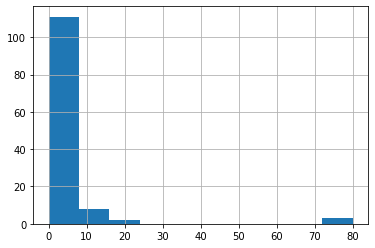

In [17]:
to_sheet_fin[(to_sheet_fin.Nonsyn<100)].Nonsyn.hist();

In [18]:
to_sheet_fin.Nonsyn.max()

552

In [19]:
descriptions

['hypothetical protein',
 'unspecified product',
 'conserved hypothetical protein']

In [20]:
non_syn_bins = [(0,1), (1,6), (6,11), (11,to_sheet_fin.Nonsyn.max()+10)]

my_ylabels = ['0','1 - 5','6 - 10','>10']

def chrom_plot(df,ax,ymod=0.15,fs=4,
               headlength=500,dy=0,
               des=descriptions):

    plt.sca(ax)
    
    for i,j in df.iterrows():
        
        plt.arrow(j.Start if j.Strand>0 else j.End,
                  j.Bin + (ymod if i%2==0 else -ymod),
                  (j.End-j.Start) * (1 if j.Strand> 0 else -1),dy,
                  length_includes_head=True,
                  head_width=0.2, 
                  head_length=headlength,
                  linewidth=1,
                  color='grey' if j['Altstop'] == 1 else 'r') 
        
        plt.text(j.Start if j.Strand>0 else j.End,
                 j.Bin + (ymod if i%2==0 else -ymod),
                 s=j.Gene,fontsize=fs,
                 va = 'top' if j.Strand>0 else 'bottom' ,ha='center',
                 color='grey' if j.Description in des else 'k')
                 

In [21]:
for i in range(len(non_syn_bins)):
    to_sheet_fin['Bin%s'%i] = -1

for i,j in to_sheet_fin.iterrows():
    for k,b in enumerate(non_syn_bins):
        to_sheet_fin.loc[i,'Bin%s'%k] = k if j.Nonsyn in np.arange(*b) else 0
        
assert to_sheet_fin[to_sheet_fin.columns[-4:]].min().min() == 0

to_sheet_fin['Bin'] = to_sheet_fin[to_sheet_fin.columns[-4:]].max(axis=1)

to_sheet_fin.drop(to_sheet_fin.columns[-5:-1],axis=1,inplace=True)

In [22]:
genes[(genes.Gene=='CNL05560')]

,Type,Gene,Start,End,Strand,Contig,Phase,Attribute,Description,Id,Seqid,Parent,Chromosome
9192,gene,CNL05560,554526,559608,1,Chr12,.,ID=CNL05560;description=ste/ste11/ssk protein ...,ste/ste11/ssk protein kinase,CNL05560,Chr12,CNL05560,12


In [23]:
chrom = 'Chr14'
test = to_sheet_fin[(to_sheet_fin.Contig==chrom)].copy().sort_values('Start')
test.tail()

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Description,Contig,Strand,Start,End,Bin
118,SS-A837,CNN01400,CNN01400-t26_1,1055.0,1055.0,1055.0,1,1,1,47,0.0,2.0,24.0,21.0,copper-exporting ATPase,Chr14,1,411604,415226,1
119,SS-A837,CNN01410,CNN01410-t26_1,883.0,883.0,883.0,1,1,2,76,1.0,1.0,14.0,60.0,putative dipeptidyl aminopeptidase,Chr14,-1,415260,418804,1
120,SS-A837,CNN01420,CNN01420-t26_1,143.0,143.0,143.0,1,1,0,9,0.0,1.0,0.0,8.0,vesicle-mediated transport-related protein,Chr14,1,418868,419847,0
121,SS-A837,CNN01430,CNN01430-t26_1,428.0,428.0,428.0,1,1,2,46,0.0,2.0,25.0,19.0,conserved hypothetical protein,Chr14,1,419898,421772,1
122,SS-A837,CNN01440,CNN01440-t26_1,274.0,274.0,274.0,1,1,1,37,0.0,1.0,5.0,31.0,hypothetical protein,Chr14,-1,421763,423131,1


In [24]:
maxqtl_info = pd.read_csv('../DATA/Max_QTL_bounds.csv',index_col=0)
maxqtl_info.head()

,Cumpos,Chrom,Max,Pos
522,3142153,Chr02,5.958631,847396
523,3143506,Chr02,6.297631,848749
524,3144731,Chr02,6.466895,849974
525,3205392,Chr02,5.130648,910635
527,3209641,Chr02,5.192451,914884


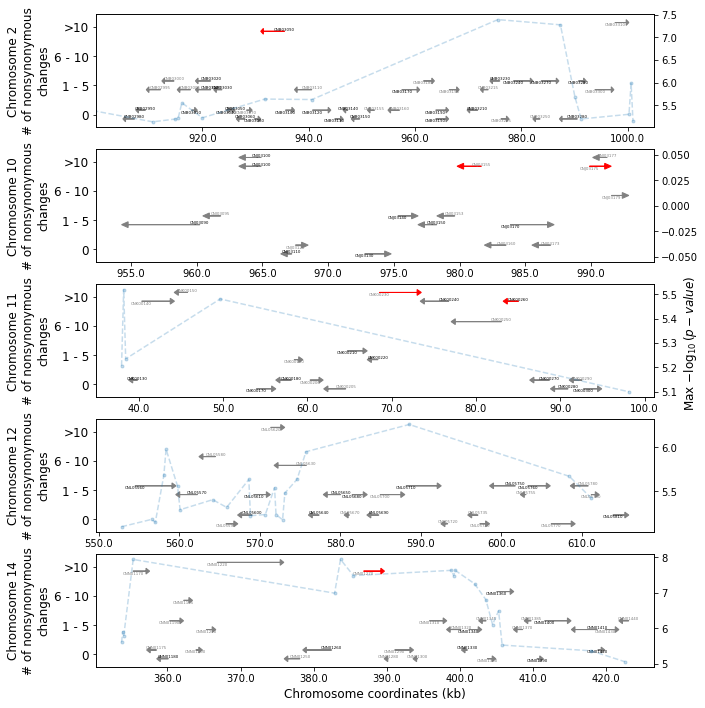

In [25]:
fig,ax = plt.subplots(to_sheet_fin.Contig.unique().shape[0],1,
                      figsize=(10,12),sharey=True)

for i,c in enumerate(sorted(to_sheet_fin.Contig.unique())):
    
    ax2 = ax.ravel()[i].twinx()
    
    plt.sca(ax2)
    
    temp = maxqtl_info[(maxqtl_info.Chrom==c)]
    
    plt.plot(temp.Pos,temp.Max,'--.',color='tab:blue',alpha=0.25)
    if c == 'Chr02':
        plt.xlim(900000,1005000);
    
    
    test = to_sheet_fin[(to_sheet_fin.Contig==c)].copy()
    
    chrom_plot(test[(test.Start>(900000 if i == 0 else 0))],
               ax.ravel()[i])
    plt.yticks(range(len(non_syn_bins)), 
               my_ylabels,fontsize=12);
    
    l,p = plt.xticks()
    plt.xticks(l[1:-1],l[1:-1]/1000)
    
    plt.ylabel('Chromosome %s\n# of nonsynonymous\nchanges'%int(c[-2:]),
               fontsize=12)
    
plt.xlabel('Chromosome coordinates (kb)',fontsize=12);
fig.text(.95,0.5,'Max $-\log_{10}\,(p-value)$',
         va='center',ha='center',
         rotation=90,fontsize=12);

#plt.savefig('../FIGURES/SUPP/S9.2_Fig.pdf',
#            dpi=300,bbox_inches='tight');

In [26]:
to_sheet_fin.Contig.unique()

array(['Chr02', 'Chr10', 'Chr11', 'Chr12', 'Chr14'], dtype=object)

In [27]:
to_sheet_fin['Chromosome'] = [int(a[-2:]) for a in to_sheet_fin['Contig']]

In [28]:
save_sheet = to_sheet_fin[['Gene','Chromosome','Start',
                            'End','Strand']].copy()

save_sheet['Variants_in_gene'] = to_sheet_fin['Nvars']
save_sheet['Upstream_variants'] = -1
save_sheet['JEC21_protein_length'] = to_sheet_fin['Expected']
save_sheet['XL280_protein_length'] = to_sheet_fin['Ref']
save_sheet['431_protein_length'] = to_sheet_fin['Alt']
save_sheet['XL280_No_stop_codons'] = to_sheet_fin['Refstop']
save_sheet['431_No_stop_codons'] = to_sheet_fin['Altstop']
save_sheet['No_nonsynonymous'] = to_sheet_fin['Nonsyn']
save_sheet['Utr_5_variants'] = to_sheet_fin['Utr5']
save_sheet['Utr_3_variants'] = to_sheet_fin['Utr3']
save_sheet['Exonic_variants'] = to_sheet_fin['Exon']
save_sheet['Intronic_variants'] = to_sheet_fin['Intron']
save_sheet['Description'] = to_sheet_fin['Description']
save_sheet['Transcript'] = to_sheet_fin['Parent']
save_sheet = save_sheet.sort_values(['Chromosome','Start'])
save_sheet.reset_index(drop=True,inplace=True)

In [29]:
for c in save_sheet.Chromosome.unique():
    for i in [1,-1]:
        
        test = save_sheet[(save_sheet.Chromosome==c) & 
                          (save_sheet.Strand==i)].copy()
        test['above'] = -1
        
        if i > 0:
            test['above'] = [500] + list(test.Start.values[1:] - test.End.values[:-1])
        else:
            test['above'] = list(test.Start.values[1:] - test.End.values[:-1])+[500]
            
        test.loc[(test.above>500),'above'] = 500
        
        for k,j in test.iterrows():
            
            if i > 0:
                d = (j.Start-j.above,j.Start)
            else:
                d = (j.End,j.End+j.above)
                
            upn = gv[(gv.Chromosome==c) & (gv.Pos.isin(np.arange(*d)))].shape[0]
            
            save_sheet.loc[k,'Upstream_variants'] = upn

In [30]:
assert save_sheet['Upstream_variants'].min() > -1

In [31]:
save_sheet[(save_sheet.Strand==1)]['Upstream_variants'].sum()

198

In [32]:
save_sheet[(save_sheet.Strand==-1)]['Upstream_variants'].sum()

185

In [33]:
save_sheet.head()

,Gene,Chromosome,Start,End,Strand,Variants_in_gene,Upstream_variants,JEC21_protein_length,XL280_protein_length,431_protein_length,XL280_No_stop_codons,431_No_stop_codons,No_nonsynonymous,Utr_5_variants,Utr_3_variants,Exonic_variants,Intronic_variants,Description,Transcript
0,CNB02870,2,849991,851458,1,9,2,102.0,102.0,102.0,1,1,0,7.0,0.0,2.0,0.0,mitochondrial 40s ribosomal protein,CNB02870-t26_1
1,CNB02880,2,850443,852241,-1,0,0,NaN,NaN,NaN,1,1,0,NaN,NaN,NaN,NaN,endoplasmic reticulum protein,NaN
2,CNB02890,2,852288,853750,-1,0,0,NaN,NaN,NaN,1,1,0,NaN,NaN,NaN,NaN,purine-specific oxidized base lesion DNA N-gly...,NaN
3,CNB02900,2,853834,855432,1,0,0,NaN,NaN,NaN,1,1,0,NaN,NaN,NaN,NaN,serine/threonine-protein kinase,NaN
4,CNB02980,2,905020,907249,-1,0,0,NaN,NaN,NaN,1,1,0,NaN,NaN,NaN,NaN,calcium:hydrogen antiporter,NaN


In [34]:
save_sheet[(save_sheet.Gene=='CNN01270')]

,Gene,Chromosome,Start,End,Strand,Variants_in_gene,Upstream_variants,JEC21_protein_length,XL280_protein_length,431_protein_length,XL280_No_stop_codons,431_No_stop_codons,No_nonsynonymous,Utr_5_variants,Utr_3_variants,Exonic_variants,Intronic_variants,Description,Transcript
113,CNN01270,14,386833,389699,1,28,6,691.0,456.0,691.0,2,0,223,2.0,1.0,23.0,2.0,hypothetical protein,CNN01270-t26_1


In [35]:
save_sheet[(save_sheet['XL280_No_stop_codons']!=1)]

,Gene,Chromosome,Start,End,Strand,Variants_in_gene,Upstream_variants,JEC21_protein_length,XL280_protein_length,431_protein_length,XL280_No_stop_codons,431_No_stop_codons,No_nonsynonymous,Utr_5_variants,Utr_3_variants,Exonic_variants,Intronic_variants,Description,Transcript
113,CNN01270,14,386833,389699,1,28,6,691.0,456.0,691.0,2,0,223,2.0,1.0,23.0,2.0,hypothetical protein,CNN01270-t26_1


In [36]:
save_sheet[(save_sheet.Chromosome==12)].head()

,Gene,Chromosome,Start,End,Strand,Variants_in_gene,Upstream_variants,JEC21_protein_length,XL280_protein_length,431_protein_length,XL280_No_stop_codons,431_No_stop_codons,No_nonsynonymous,Utr_5_variants,Utr_3_variants,Exonic_variants,Intronic_variants,Description,Transcript
78,CNL05560,12,554526,559608,1,42,9,1486.0,1486.0,1486.0,1,1,3,0.0,2.0,28.0,12.0,ste/ste11/ssk protein kinase,CNL05560-t26_1
79,CNL05570,12,559574,562278,-1,58,1,718.0,718.0,718.0,1,1,5,0.0,0.0,27.0,31.0,delta-pyrroline-5-carboxylate,CNL05570-t26_1
80,CNL05580,12,562457,564519,-1,85,5,459.0,459.0,459.0,1,1,10,0.0,9.0,42.0,34.0,hypothetical protein,CNL05580-t26_1
81,CNL05590,12,565802,567289,1,23,8,229.0,229.0,229.0,1,1,0,0.0,9.0,5.0,9.0,hypothetical protein,CNL05590-t26_1
82,CNL05600,12,567255,569092,-1,20,3,394.0,394.0,394.0,1,1,0,0.0,0.0,9.0,11.0,pyruvate dehydrogenase e1 component beta subunit,CNL05600-t26_1


In [38]:
save_sheet.groupby('Chromosome').count()

,Gene,Start,End,Strand,Variants_in_gene,Upstream_variants,JEC21_protein_length,XL280_protein_length,431_protein_length,XL280_No_stop_codons,431_No_stop_codons,No_nonsynonymous,Utr_5_variants,Utr_3_variants,Exonic_variants,Intronic_variants,Description,Transcript
Chromosome,,,,,,,,,,,,,,,,,,
2,43,43,43,43,43,43,35,35,35,43,43,43,35,35,35,35,43,35
10,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
11,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
12,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25
14,29,29,29,29,29,29,28,28,28,29,29,29,28,28,28,28,29,28


In [43]:
save_sheet[(save_sheet.Variants_in_gene>0) & 
           (save_sheet.No_nonsynonymous>0)].groupby('Chromosome').count()

,Gene,Start,End,Strand,Variants_in_gene,Upstream_variants,JEC21_protein_length,XL280_protein_length,431_protein_length,XL280_No_stop_codons,431_No_stop_codons,No_nonsynonymous,Utr_5_variants,Utr_3_variants,Exonic_variants,Intronic_variants,Description,Transcript
Chromosome,,,,,,,,,,,,,,,,,,
2,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
10,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
11,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
12,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
14,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17


In [60]:
for c in save_sheet.Chromosome.unique().tolist():
    left = save_sheet[(save_sheet.Chromosome==c)].Start.min()
    right = save_sheet[(save_sheet.Chromosome==c)].End.max()
    
    ng = genes[(genes.Start>=left) & 
               (genes.End<=right) & 
               (genes.Chromosome==c)].shape[0]
    print(c,left,right,ng)

2 849991 1000228 50
10 954270 992892 16
11 38768 94916 19
12 554526 615839 28
14 355281 423131 37


In [53]:
save_sheet[(save_sheet.Chromosome==10)].shape

(17, 19)

In [59]:
genes[(genes.Start>=847000) & (genes.End<=1001000) & (genes.Chromosome==2)]

,Type,Gene,Start,End,Strand,Contig,Phase,Attribute,Description,Id,Seqid,Parent,Chromosome
88830,gene,CNB02860,847924,849735,1,Chr02,.,ID=CNB02860;description=tRNA adenylyltransfera...,tRNA adenylyltransferase,CNB02860,Chr02,CNB02860,2
21711,gene,CNB02870,849991,851458,1,Chr02,.,ID=CNB02870;description=mitochondrial 40s ribo...,mitochondrial 40s ribosomal protein,CNB02870,Chr02,CNB02870,2
54644,gene,CNB02880,850443,852241,-1,Chr02,.,ID=CNB02880;description=endoplasmic reticulum ...,endoplasmic reticulum protein,CNB02880,Chr02,CNB02880,2
93250,gene,CNB02890,852288,853750,-1,Chr02,.,ID=CNB02890;description=purine-specific oxidiz...,purine-specific oxidized base lesion DNA N-gly...,CNB02890,Chr02,CNB02890,2
68357,gene,CNB02900,853834,855432,1,Chr02,.,ID=CNB02900;description=serine/threonine-prote...,serine/threonine-protein kinase,CNB02900,Chr02,CNB02900,2
97817,gene,CNB02910,856391,862531,1,Chr02,.,ID=CNB02910;description=unspecified product,unspecified product,CNB02910,Chr02,CNB02910,2
5102,gene,CNB02920,865718,877049,-1,Chr02,.,ID=CNB02920;description=unspecified product,unspecified product,CNB02920,Chr02,CNB02920,2
30571,gene,CNB02930,878788,885478,-1,Chr02,.,ID=CNB02930;description=unspecified product,unspecified product,CNB02930,Chr02,CNB02930,2
77305,gene,CNB02940,885478,890152,1,Chr02,.,ID=CNB02940;description=unspecified product,unspecified product,CNB02940,Chr02,CNB02940,2
52502,gene,CNB02950,890375,896150,-1,Chr02,.,ID=CNB02950;description=unspecified product,unspecified product,CNB02950,Chr02,CNB02950,2


In [37]:
save_sheet.to_csv('../DATA/Supplementary_Table_2.csv',
                    index=False)